# Traffic Intersection

### Introduction

The aim of this project is to explore how traffic patterns impact traffic flow. This work expands upon Nagel Schreckenberg's one-way ring road (Nagel & Schreckenberg, 1992) by incorporating an additional intersecting lane and a traffic light at the intersection. The project will answer how this simulation can be used in real life and explore the notion of optimisation in terms of traffic lights. The paper will also propose a number of extensions that this simulation could begin to incorporate or accomodate or account for. 

### Rules of the Simulation

The following are rules used in the update section of the simulation. These are the rules that the simulation follows at each time step. Rules 1, 2, 3 and 5 are from the Nagel Schreckenberg Model. Rule 4 was developed for the purposes of this extension.

#### Rule 1
If the car is travelling below maximum velocity AND the distance to the car directly in front is larger than the current velocity plus one, increase the velocity of the car by one. This is the rule for acceleration.

e.g. The car is travelling at 2, the maximum velocity is 5, and the distance to the next car is 5. The car is updated to a velocity of 3.

#### Rule 2
If the distance to the car directly in front is less than OR equal to the current velocity, decrease the velocity of the car to the distance to the next car minus one. This is to avoid collisions.

e.g. The car is travelling at 5 and the distance to the next car is 4. The car is updated to a velocity of 3.

#### Rule 3
If the current car velocity is larger than zero, with a certain probability, reduce the current velocity by one. This adds a degree of randomness to the simulation.

e.g. The car is travelling at 3, with a 10% probability, update the velocity of the car to 2

#### Rule 4
If the traffic light is red, the velocity of the car is reduced to the distance to the traffic light minus one, bringing the car to a stop at the light.
If the traffic light is green, the car travels as usual. Unless the car will update into the middle of the intersection. In that case, if the car is not at maximum velocity, the car speeds up through the intersection by one. If the car is travelling at maximum velocity, it slows down by one to avoid being caught in the middle of the intersection.

e.g. The light is red, the car is travelling at 4, the distance to the traffic light is 2. The velocity of the car is updated to 1.

e.g. The light is green, the car is travelling at 3, the distance to the traffic light is 2. The velocity of the car is not updated by this rule

e.g. The light is green, the car is travelling at 2, the maximum velocity is 5, the distance to the traffic light is 2. The velocity of the car is updated to 3.

e.g. The light is green, the car is travelling at 5, the maximum velocity is 5, the distance to the traffic light is 5. The velocity of the car is updated to 4.

#### Rule 5
The cars move forward in accordance with their velocities with each time step.

e.g. The car is travelling at 4. The car's position is updated to be positioned 4 steps in front of where it previously was.

### Assumptions

Most, if not all, simulations have assumptions built into them, and this simulation model is no different. Below are some of the key assumptions:

- Cars do not overtake each other
- There are no accidents
- Cars respect the traffic signal
- Cars do not turn at the intersection
- All cars behave and act by the same rules

### Simulation Code

The code in the following section builds off the work I produced for CS166 wherein the basic Nagel Schreckenberg model was implemented in Python. Having said that, I believe that the code from CS166 was worked on significantly. The code from which I have extended upon is included in part 1 of the appendix.

In [1]:
import scipy
import random

class TrafficIntersection(object):
    
    def __init__(self, TDensity, MaxV, SDown, RLength = 17, TSwitch = 5):
        '''
        Initialises a number of important variables
        that are called upon in the other methods
        '''
        # Length of the road
        self.RoadLength = RLength
        
        # Density of cars on each road
        self.TrafficDensity = TDensity
        
        # Maximum velocity cars will travel at
        self.MaximumVelocity = MaxV
        
        # The probability that a car will slow down
        self.ProbSlowingDown = SDown
        
        # The number of cars on the road
        self.NumberOfCars = int(self.TrafficDensity*self.RoadLength)
        
        # Which row and column the intersection will occur at
        self.intersect = int((self.RoadLength-1)/2)
        
        # Amount of time steps before the traffic light changes
        self.traffic_switch = TSwitch
     
    
    def set_cars(self):
        '''
        Builds the road and intersection before setting cars onto 
        the road at random with the same number of cars on each road
        '''
        # creates a [RoadLength] element long scipy array of zeroes 
        self.road = scipy.zeros((self.RoadLength, self.RoadLength))
        
        # randomises where the cars will be initialised
        self.horizontal_cars = random.sample(xrange(0, self.RoadLength - 1), self.NumberOfCars)
        self.vertical_cars = random.sample(xrange(0, self.RoadLength - 1), self.NumberOfCars)
        
        # avoids cars being placed at the intersection
        while self.intersect in self.horizontal_cars:
            self.horizontal_cars = random.sample(xrange(0, self.RoadLength - 1), self.NumberOfCars)
        while self.intersect in self.horizontal_cars:
            self.vertical_cars = random.sample(xrange(0, self.RoadLength - 1), self.NumberOfCars)
              
        # change the grid to a matrix of -2 to convey negative space
        self.road[self.road == 0] = -2
        
        # change rows and columns along intersection to -1 to convey roads
        self.road[self.intersect] = [-1 for i in self.road[self.intersect]]
        for i in self.road:
            i[self.intersect] = -1
        
        # randomises the velocity of the cars
        for j in self.horizontal_cars:
            self.road[self.intersect, j] = random.randint(0,self.MaximumVelocity)
        for j in self.vertical_cars:
            self.road[j, self.intersect] = random.randint(0,self.MaximumVelocity)

    
    def set_trafficlight(self):
        '''
        Sets up a traffic light at the intersection
        '''
        # assigns -3 to the intersection point to represent the traffic light
        self.road[self.intersect, self.intersect] = -3

        # identifies different light patterns for the verical and horizontal lanes
        self.vertical_lightstatus = 'red'
        self.horizontal_lightstatus = 'green'

        # amount of time the traffic light has stayed the same colour
        self.time_interval = 0
        

    def update(self):
        self.horizontal_update()
        self.vertical_update()
        self.traffic_update()
        

    def horizontal_update(self):
        '''
        Updates the movement and velocity of the horizontal cars by one time step
        '''
        self.horizontal_cars.sort()
        for c in range(self.NumberOfCars):
            
            # Calculates the distance between one car and the next
            distance = ((self.horizontal_cars[(c+1)%self.NumberOfCars]) - (self.horizontal_cars[c]))%self.RoadLength
            TLdistance = ((self.intersect) - (self.horizontal_cars[c]))
            
            # Rule 1:
            # if the car is not at maximum velocity
            # and the distance to the next car is larger than the current velocity plus one
            # increase velocity by one
            if self.road[self.intersect, self.horizontal_cars[c]] < self.MaximumVelocity and distance > self.road[self.intersect, self.horizontal_cars[c]] + 1:
                # Increase velocity by one
                self.road[self.intersect, self.horizontal_cars[c]] += 1
            
            # Rule 2:
            # if the distance to the next car is less than or equal to the current velocity
            # decrease velocity to the distance to the next car minus one
            if distance <= self.road[self.intersect, self.horizontal_cars[c]]:
                # Decrease velocity by one
                self.road[self.intersect, self.horizontal_cars[c]] = distance - 1
            
            # Rule 3:
            # if the current velocity is larger than zero
            # reduce the current velocity by one with specified probability
            if self.road[self.intersect, self.horizontal_cars[c]] > 0 and random.uniform(0,1) < self.ProbSlowingDown:
                self.road[self.intersect, self.horizontal_cars[c]] -= 1
                
            # Rule 4:
            # if the Traffic light is red, decrease the velocity to the distance
            # to the traffic light minus one
            if self.horizontal_lightstatus == 'red' and TLdistance > 0 and TLdistance <= self.MaximumVelocity:
                if TLdistance <= self.road[self.intersect, self.horizontal_cars[c]]:
                    self.road[self.intersect, self.horizontal_cars[c]] = TLdistance - 1
                    
            # if the traffic light is green, the car travels past or just before the traffic light
            if self.horizontal_lightstatus == 'green' and TLdistance > 0 and TLdistance <= self.MaximumVelocity:
                if TLdistance == self.road[self.intersect, self.horizontal_cars[c]]:
                    if self.road[self.intersect, self.horizontal_cars[c]] != self.MaximumVelocity:
                        self.road[self.intersect, self.horizontal_cars[c]] = TLdistance + 1
                    else:
                        self.road[self.intersect, self.horizontal_cars[c]] = TLdistance - 1
        
        for c in range(self.NumberOfCars):     
            # Rule 5:
            # update position of the cars using their velocity to determine the number of cells they move forward
            velocity = int(self.road[self.intersect, self.horizontal_cars[c]])
            position = self.horizontal_cars[c]
            self.road[self.intersect, (position + velocity)%self.RoadLength] = velocity
            
            # if the car doesn't move, we don't reset it to an empty cell
            if self.road[self.intersect, position] > 0:
                self.road[self.intersect, position] = -1
            
            self.horizontal_cars[c] = int((position + velocity)%self.RoadLength)
            
            # If a car travels past the 'end', we add one to the flow count
            if position + velocity > self.RoadLength:
                self.horizontal_flow += 1
        

    def vertical_update(self):
        '''
        Updates the movement and velocity of the vertical cars by one time step
        '''

        self.vertical_cars.sort()
        for c in range(self.NumberOfCars):
            
            # Calculates the distance between one car and the next
            distance = ((self.vertical_cars[(c+1)%self.NumberOfCars]) - (self.vertical_cars[c]))%self.RoadLength
            TLdistance = ((self.intersect) - (self.vertical_cars[c]))
            
            # Rule 1:
            # if the car is not at maximum velocity
            # and the distance to the next car is larger than the current velocity plus one
            # increase velocity by one
            if self.road[self.vertical_cars[c], self.intersect] < self.MaximumVelocity and distance > self.road[self.vertical_cars[c], self.intersect] + 1:
                # Increase velocity by one
                self.road[self.vertical_cars[c], self.intersect] += 1
            
            # Rule 2:
            # if the distance to the next car is less than or equal to the current velocity
            # decrease velocity to the distance to the next car minus one
            if distance <= self.road[self.vertical_cars[c], self.intersect]:
                # Decrease velocity by one
                self.road[self.vertical_cars[c], self.intersect] = distance - 1
            
            # Rule 3:
            # if the current velocity is larger than zero
            # reduce the current velocity by one with specified probability
            if self.road[self.vertical_cars[c], self.intersect] > 0 and random.uniform(0,1) < self.ProbSlowingDown:
                self.road[self.vertical_cars[c], self.intersect] -= 1
                
            # Rule 4:
            # if the Traffic light is red, decrease the velocity to the distance
            # to the traffic light minus one
            if self.vertical_lightstatus == 'red' and TLdistance > 0 and TLdistance <= self.MaximumVelocity:
                if TLdistance <= self.road[self.vertical_cars[c], self.intersect]:
                    self.road[self.vertical_cars[c], self.intersect] = TLdistance - 1
                    
            # if the traffic light is green, the car travels past or just before the traffic light
            if self.vertical_lightstatus == 'green' and TLdistance > 0 and TLdistance <= self.MaximumVelocity:
                if TLdistance == self.road[self.vertical_cars[c], self.intersect]:
                    if self.road[self.vertical_cars[c], self.intersect] != self.MaximumVelocity:
                        self.road[self.vertical_cars[c], self.intersect] = TLdistance + 1
                    else:
                        self.road[self.vertical_cars[c], self.intersect] = TLdistance - 1
        
        for c in range(self.NumberOfCars):     
            # Rule 5:
            # update position of the cars using their velocity to determine the number of cells they move forward
            velocity = int(self.road[self.vertical_cars[c], self.intersect])
            position = self.vertical_cars[c]
            self.road[(position + velocity)%self.RoadLength, self.intersect] = velocity
            
            # if the car doesn't move, we don't reset it to an empty cell
            if self.road[position, self.intersect] > 0:
                self.road[position, self.intersect] = -1
            
            self.vertical_cars[c] = int((position + velocity)%self.RoadLength)
            
            # If a car travels past the 'end', we add one to the flow count
            if position + velocity > self.RoadLength:
                self.vertical_flow += 1
    
    
    def traffic_update(self):
        '''
        Updates the traffic light by one time step
        '''
        self.time_interval += 1
        
        if self.time_interval == self.traffic_switch:
            if self.vertical_lightstatus == 'red':
                self.vertical_lightstatus = 'green'
            else:
                self.vertical_lightstatus = 'red'
                
        if self.time_interval == self.traffic_switch:
            if self.horizontal_lightstatus == 'red':
                self.horizontal_lightstatus = 'green'
            else:
                self.horizontal_lightstatus = 'red'
        
            self.time_interval = 0
                

    def display(self):
        '''
        Displays the grid more visually intuitive
        '''
        for y in self.road:
            disp = []
            for x in y:
                if x == -1:
                    disp.append('.')
                elif x == -2:
                    disp.append(' ')
                elif x == -3:
                    disp.append('T')
                else:
                    disp.append(str(int(x)))
            print(''.join(disp))
            
    
    def visualise(self, steps = 20):
        '''
        Prints each time step out
        '''
        count = 0
        self.horizontal_flow = 0
        self.vertical_flow = 0
        while count < steps:
            self.update()
            self.display()
            count += 1   
            print("\n")
            
            
    def traffic_flow(self, steps = 20):
        '''
        Returns the traffic flow of x time steps for 
        both the horizontal and vertical lanes
        '''
        count = 0
        self.horizontal_flow = 0
        self.vertical_flow = 0
        while count < steps:
            self.update()
            count += 1
        return [(float(self.horizontal_flow)/steps), (float(self.vertical_flow)/steps)]
    
    
    def traffic_flows(self, steps = 20, times = 200):
        '''
        Prints a list of y traffic flows based on x time steps
        '''
        self.flows = []
        count = 0
        while count < times:
            self.flows.append(self.traffic_flow(steps))
            count += 1
        return self.flows

### Simulation Visualisation

It is difficult to visualise a two-dimensional visualisation over time on a pdf. As such, I have included code that can be run to display the time steps in part 2 of the appendix.

### Traffic Flow Plot Code

The following section takes the simulation and runs it multiple times in order to generate traffic flow data based on different traffic light time intervals. It then plots two graphs based on traffic light time interval and traffic flow, one for the vertical lane and one for the horizontal lane. Traffic flow here plays into the view that cities can be seen as flows (Batty & Cheshire, 2011). That can be information, capital, physical, or in this case traffic. Measuring traffic flow is about identifying flow at a fixed point over time. In this case, it is about how often do cars get to the end of the road and circle back, averaged out over the number of time steps the simulation is run. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def traffic_flow_chart(traffic_density, road_length):
    switch_time = 1
    horizontal_traffic_flows = []
    vertical_traffic_flows = []
    traffic_switches = []
    while switch_time <= 15:
        count = 0
        horizontal_traffic_flow = []
        vertical_traffic_flow = []
        while count < 50:
            count += 1
            test = TrafficIntersection(TDensity = traffic_density, MaxV = 5, SDown = 0, RLength = road_length, TSwitch = switch_time)
            test.set_cars()
            test.set_trafficlight()

            hold = test.traffic_flow(500)

            horizontal_traffic_flow.append(hold[0])
            vertical_traffic_flow.append(hold[1])

        horizontal_traffic_flows.append(np.mean(horizontal_traffic_flow))
        vertical_traffic_flows.append(np.mean(vertical_traffic_flow))
        traffic_switches.append(switch_time)
        switch_time += 1

    plt.plot(traffic_switches, horizontal_traffic_flows)
    plt.title("Horizontal Traffic Flows based on Traffic Light Time Interval (TDensity = %.2f, Rlength = %d)" % (traffic_density, road_length))
    plt.xlabel("Traffic Light Time Interval")
    plt.ylabel("Traffic Flow")
    plt.show()
    plt.plot(traffic_switches, vertical_traffic_flows)
    plt.title("Vertical Traffic Flows based on Traffic Light Time Interval (TDensity = %.2f, Rlength = %d)" % (traffic_density, road_length))
    plt.xlabel("Traffic Light Time Interval")
    plt.ylabel("Traffic Flow")
    plt.show()

### Traffic Flow Plot Analysis

Using the code directly above, the following plots on traffic flow against traffic light time interval are analysed on the basis that a road with more cars or longer distances without a traffic light are contributing factors to the traffic flow of a simulation.

#### Changing Traffic Density (Number of cars on the road)

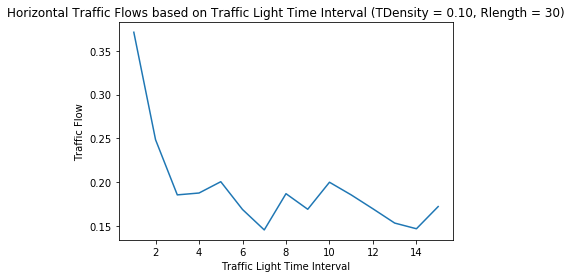

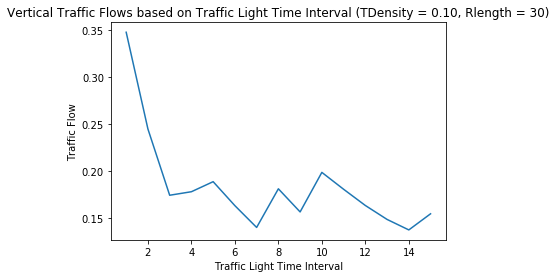

In [3]:
traffic_flow_chart(0.1, 30)

With a low density of cars on the road, it appears that longer time intervals is a hinderance to traffic flow. The explanation for this would be that cars are waiting at the traffic light when the road is clear. This creates a lot of idle wait time for cars stopped at a traffic light despite the road being clear and safe for them to continue their journey.

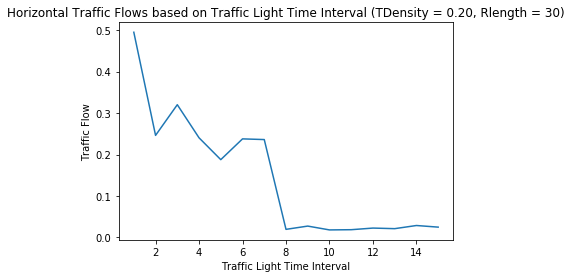

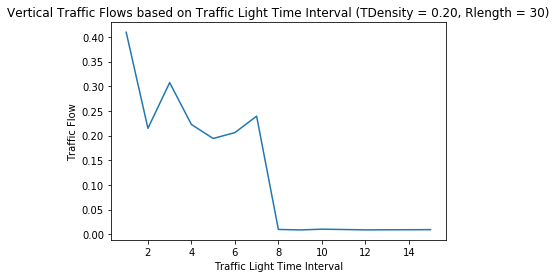

In [4]:
traffic_flow_chart(0.2, 30)

With slightly more cars on the road, the plot is showing that there is good traffic flow for time intervals up to around 8 time steps. Again this seems intuitive as since there are more cars, traffic flow remains relatively high  for a slightly longer time interval at the traffic light. Cars that piled up when the light is red are given a chance to pass through the intersection when it turns green.

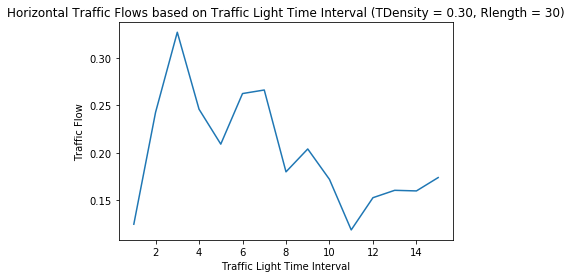

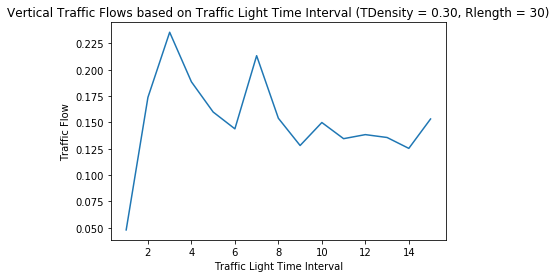

In [5]:
traffic_flow_chart(0.3, 30)

The next two plots begin to get more interesting as the similarities between the vertical and horizontal traffic flows begin to break away - unlike when there was a lower density of cars. With more cars on the road, there doesn't seem to be as significant a drop as the time interval increases. This is likely because there are consistent amount of cars being released at the traffic signal. Almost like a release valve, a set number of cars pass through the traffic intersection and to the end of the road, joining the back of the queue at the traffic intersection again.

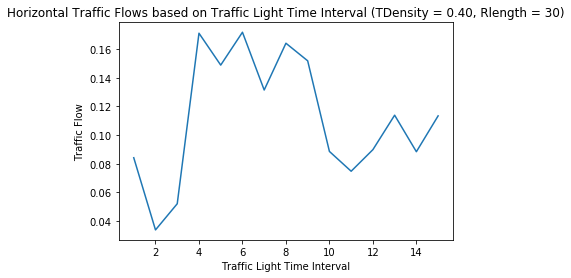

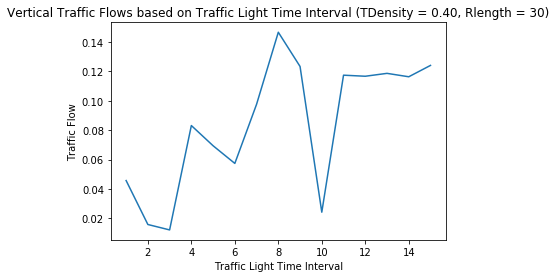

In [6]:
traffic_flow_chart(0.4, 30)

As with the previous plot pair, there is significant deviation between both plots here. It is not clear what accounts for the uncharacteristic trough at the 10 time step time interval for vertical flows but curiously the plateau at the high end of the time interval matches that of perviously less dense roads. This can be see that the traffic flow falls around 0.15 at the 15 time step time interval for many of the above plots (the axis scales differently on different plots to accomodate different variance in data). The explanation for this is that the cars released when the light turns green join the back of the queue, hence there is no difference in traffic flow regardless of density of cars on the road when the time interval is high.

#### Changing Length of the Road (Distance before encountering the traffic light again)

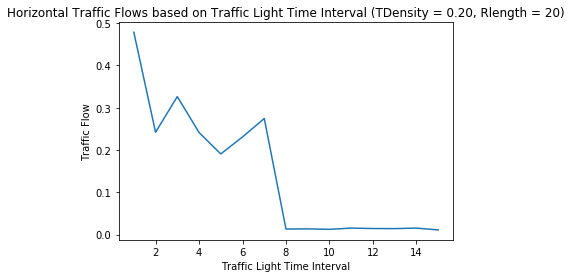

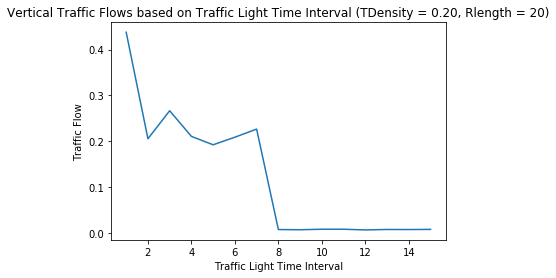

In [7]:
traffic_flow_chart(0.2, 20)

With a small distance between encountering the traffic light again, the plots mirror each other and there is a plateau at the high end of the time interval. This pair of plots is better analysed in conjunction with the next pair because they behave very similarly. This can be seen by the similarity in the plots.

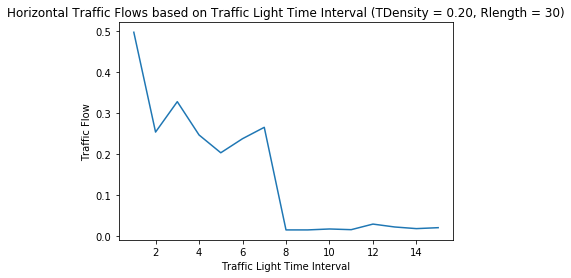

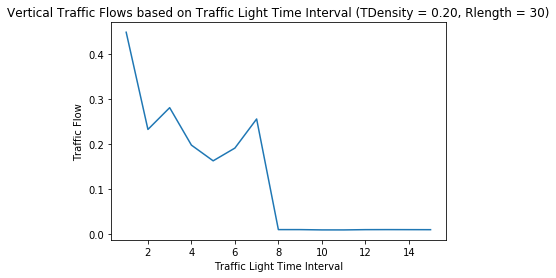

In [8]:
traffic_flow_chart(0.2, 30)

As mentioned above, regardless of the road length being 20 or 30, the traffic flow behaviour remains very similar. Bear in mind that the number of cars on the road is still proportional to the length of the road. The optimal time interval for maximising traffic flow appears to be closer to zero as that msot likely allows cars to go right through the traffic intersection, rarely having to slow down or come to a complete stop at the traffic light.

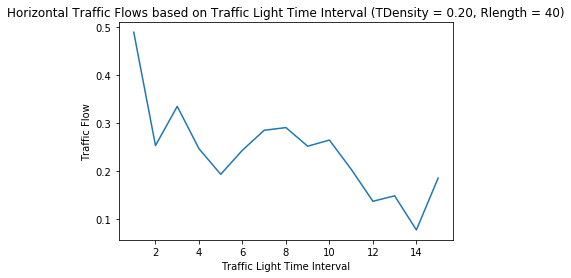

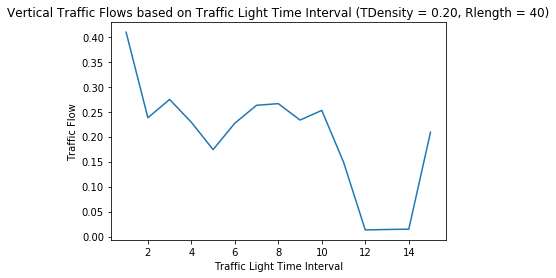

In [9]:
traffic_flow_chart(0.2, 40)

This is probably the most perplexing of all the plot pairs as the steady decline is interrupted by a deep trough and a significant incline at the 12 and 14 time step time interval mark. The steady decline is explanable by the reasonings presented in previous plot pairs but the uptick at the 15 time step time interval is curious.

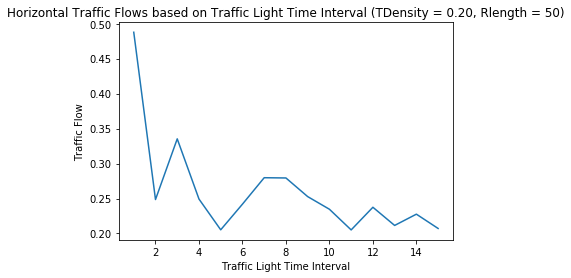

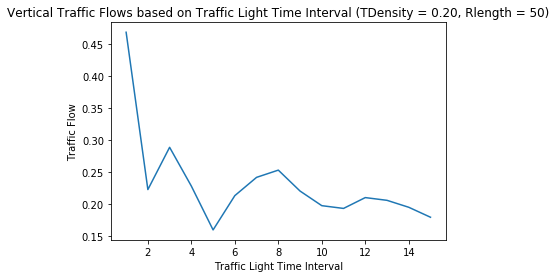

In [10]:
traffic_flow_chart(0.2, 50)

As the road length increases even further, the same overall trend is identifiable but more importantly, the plateau appears to be relatively higher than the previous instances. Traffic flow plateaus at around the 0.20 mark suggesting that since these simulations were set with a 0 parameter for probability of random slowing down, the traffic light is the most significant factor for causing cars to come to a halt. So the longer runway there is for cars to continue without slowing down means that there are less instances where cars do not pass through the end of the road at each time step. 

### Conclusion

#### Density of Cars
There is a uniform figure for traffic flow when the traffic light time interval is set at the high end. This is most likely due to there being a traffic build up at the intersection with a steady amount of cars being released, only to join the back of the traffic queue again. What can be seen is that different density of cars on the road has a significant impact on traffic flow even at differnt traffic light time intervals. The question of universal optimality begins to be challenged because the optimal time interval at a traffic light is dependent on the density of cars on the road. A lower density of cars on the road welcomes a relatively lower but not extremely low time interval at the traffic light. This is where the concept and reality of adaptive traffic lights begins to achieve a better degree of traffic flow for cars if they are programmed to allow cars to go through based on a more fluid set of rules - i.e. not a static time interval. 


#### Distance between encountering the same traffic light 
The overall trend remains the same with each plot pair but what is noticeable is the plateau that each plot pair appears to reach. As the road length increases, the plateau also seems to increase. Up to around 0.20 traffic flow. This is explained by the probability of random slowing down for these particular instances being set to zero. The main factor slowing cars down to zero is the traffic light and thus a larger distance between encountering the traffic light will increase the traffic light slightly. 

### Data Visualisation Principles

In line with what we have learned from the course, the above visualisations were produced with the principles from "Intro Data Viz" reading as part of the Computational Urbanism course ("Data visualization: basic principles", 2016). A clearly readable and understandable title is used, with the changing parameter values included. The axis are labelled appropriately for readability. A line chart is used because the plots are trying to convey a change of traffic flow with different time intervals. The line chart offers the ability to see a trend with the change in time interval wherein the slope of the line and overall trajectory display change in a visually intuitive sense and suggests overall trends of the data.

### Real-life Application

This project assumptions and rules remain fairly basic and might at first glance seem not to be realistic enough to aid any real life application but as was discussed in the Computational Urbanism tutorial, the simulation is a reduction of complex behaviours that occur at a traffic intersection and this basic model of it goes a long way in being able to generate results but also readability. The applications of this project can range across multiple situations but the primary result will surround a better understanding of how traffic lights can alter the way traffic in a city moves. Whether the situation calls for the alleviation of traffic jams, or a better understanding of traffic pile up, or curiosities about replicating a traffic intersection at an actual intersection, this project provides some answers and a simulation model to address these concerns.

### Extensions to this model

- Two lane road

The idea of introducing a two lane road is both about introducing the ability to overtake other vehicles and the introduction of an opposing lane. Both these features would allow the simulation to explore more realistic situations. The ability to switch lanes would have an impact on cars that slow down due to the probability parameter built into the simulation. Having an opposing lane might not seem significant at first, but the next extension idea elevates it.

- Turning

The explicit assumption in this simulation include the fact that cars do not turn at the intersection. To introduce turning would be to introduce more actions and possibilities. It is not just the outcome of the traffic flows since road density could change but rather the rules that occur at a traffic intersection. For instance, it would allow the simulation to explore the posssibility that cars can turn onto a road based on rules rather than a traffic signal and much more. 

- Crosswalk

At its core, the simulation is about analysing a traffic intersection. In this project, traffic flow is the measurement of choice, but an intersection has much more activity than cars. In our class on urban discourses, the topic of walkable city arose. By introducing crosswalks into this project, there would be a competing measure that lends itself to a conversation on optimality. Should the traffic intersection prioritise people or cars? Urban discourses are a lens in which we can view and examine the city from (Karsten, 2009). It allows us to explore the optimal situations from different perspectives.

### References

- Batty, M., & Cheshire, J. (2011). Cities as Flows, Cities of Flows. Environment And Planning B: Planning And Design, 38(2), 195-196. doi: 10.1068/b3802ed


- Data visualization: basic principles. (2016). Retrieved from http://paldhous.github.io/ucb/2016/dataviz/week2.html


- Karsten, L. (2009). From a top-down to a bottom-up urban discourse: (re) constructing the city in a family-inclusive way. Journal Of Housing And The Built Environment, 24(3), 317-329. doi: 10.1007/s10901-009-9145-1


- Nagel, K., & Schreckenberg, M. (1992). A cellular automaton model for freeway traffic. Journal De Physique I, 2(12), 2221-2229. doi: 10.1051/jp1:1992277


\* all four references are part of the reading list for Computational Urbanism Tutorial

### Appendix

#### Part 1 - Basic Nagel Schreckenberg simulation model that was extended upon

In [ ]:
import random
import scipy

class TrafficSimulation(object):

    def __init__(self, RLength, TDensity, MaxV, SDown):
        
        # Length of the road
        self.RoadLength = RLength
        
        # Density of cars on the road
        self.TrafficDensity = TDensity
        
        # Maximum velocity cars will travel at
        self.MaximumVelocity = MaxV
        
        # The probability that a car will slow down
        self.ProbSlowingDown = SDown
        
        # The number of cars on the road
        self.NumberOfCars = int(self.TrafficDensity*self.RoadLength)
        
    def set_cars(self):
        
        # creates a [RoadLength] element long scipy array of zeroes 
        self.road = scipy.zeros(self.RoadLength)
        
        # randomises where the cars are initialised
        self.cars = random.sample(xrange(0, self.RoadLength - 1), self.NumberOfCars)
        
        # changes the zeroes to a -1 in the scipy array
        for i in range(0, self.RoadLength):
            self.road[i] = -1
            
        # randomises the velocity of the cars
        for j in self.cars:
            self.road[j] = random.randint(0,self.MaximumVelocity)
        
        print self.cars
    
    def update(self):
        self.cars.sort()
        for c in range(len(self.cars)):
            
            # Calculates the distance between one car and the next
            distance = ((self.cars[(c+1)%self.NumberOfCars]) - (self.cars[c]))%self.RoadLength
            
            # Rule 1:
            if self.road[self.cars[c]] < self.MaximumVelocity and distance > self.road[self.cars[c]] + 1:
                # Increase velocity by one
                self.road[self.cars[c]] += 1
            
            # Rule 2:
            if distance <= self.road[self.cars[c]]:
                # Decrease velocity by one
                self.road[self.cars[c]] = distance - 1
            
            # Rule 3:
            if self.road[self.cars[c]] > 0 and random.uniform(0,1) < self.ProbSlowingDown:
                self.road[self.cars[c]] -= 1
        
        for c in range(len(self.cars)):     
            # Rule 4:
            velocity = int(self.road[self.cars[c]])
            position = self.cars[c]
            self.road[(position + velocity)%self.RoadLength] = velocity
            if self.road[position] > 0:
                self.road[position] = -1
            self.cars[c] = int((position + velocity)%self.RoadLength)

    def display(self):
        print(''.join('.' if x == -1 else str(int(x)) for x in self.road))

In [ ]:
original = TrafficSimulation(100, 0.2, 5, 0.5)
original.set_cars()
original.display()
count = 0
while count < 30:
    original.update()
    original.display()
    count += 1

#### Part 2 - Visualisation of the simulation for ten time-steps

In [ ]:
vis = TrafficIntersection(TDensity = 0.2, MaxV = 5, SDown = 0, RLength = 30, TSwitch = 5)
vis.set_cars()
vis.set_trafficlight()

# vis.visualise(10)
# vis.display()
# print vis.traffic_flows(500,20)
# print vis.traffic_flow(100)